In [1]:
import cv2
import numpy as np
from PIL import Image
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import joblib

2023-05-05 15:28:18.955848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [3]:
# 이미지 경로 배열 만들기
paths = []
for i in range(1, 4+1):
    path = []
    for j in range(13):
        path.append(f'images/train/{i}/{j}.jpeg')
    paths.append(path)

In [4]:
def load_image(path):
    return cv2.flip(cv2.imread(path), 1)

In [5]:
# 이미지를 회전한 후 결과를 리턴하는 함수
def rotate_image(path, degree=0):
    pil_image = Image.open(path)
    rotate_image = pil_image.rotate(degree)
    np_image = np.array(rotate_image)
    cv_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return cv_image

In [6]:
# OpenCV 이미지를 출력하는 함수
def show_image(image):
    annotated_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(annotated_image)
    plt.axis('off')

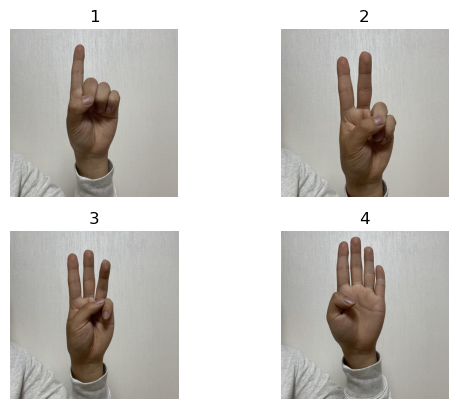

In [7]:
# 1~4 손 이미지 나타내기
fig = plt.figure()
for i in range(1, 4+1):
    fig.add_subplot(2, 2, i)
    plt.title(i)
    image = load_image(paths[i-1][0])
    show_image(image)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


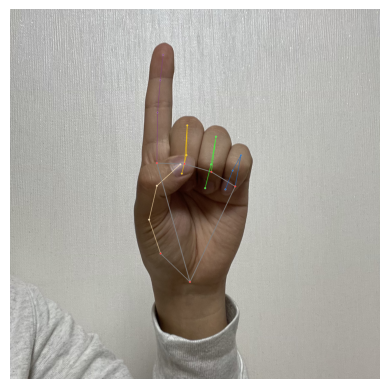

In [8]:
# MediaPipe Hands 모듈의 예시
with mp_hands.Hands(static_image_mode=True) as hands:
    image = load_image(paths[0][0])
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.multi_hand_landmarks[0],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        show_image(image)

In [9]:
# 모델 훈련 시 사용
X = []
y = []

# 1~4까지의 숫자 이미지를 MediaPipe Hands를 통해 특징점 추출
# 이미지의 개수를 늘리기 위해 -15도 ~ 15도 회전
with mp_hands.Hands(static_image_mode=True) as hands:
    for i in range(1, 4+1):
        for path in paths[i-1]:
            for degree in range(-15, 16):
                image = rotate_image(path, degree)
                results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                
                if results.multi_hand_landmarks:
                    landmark = results.multi_hand_landmarks[0].landmark
                    
                    # 모델 학습을 위해 3차원 landmark 클래스 결과 값을 1차원 배열로 변환
                    coordinate = []
                    for n in range(21):
                        coordinate.extend([landmark[n].x, landmark[n].y])
                    
                    X.append(coordinate)
                    y.append(i)

print(f'분석한 전체 이미지 개수: {len(X)}')
print(f'숫자 {y[0]}을 MediaPipe를 통해 분석한 결과')
print(X[0])

분석한 전체 이미지 개수: 1576
숫자 1을 MediaPipe를 통해 분석한 결과
[0.4633544087409973, 0.7139135003089905, 0.5491211414337158, 0.6728873252868652, 0.6046373248100281, 0.5902127027511597, 0.606312096118927, 0.5033648014068604, 0.5545951128005981, 0.43967172503471375, 0.6242638826370239, 0.4341535270214081, 0.6554540991783142, 0.30866169929504395, 0.6713279485702515, 0.2234605997800827, 0.6791882514953613, 0.15580332279205322, 0.5498334765434265, 0.42289310693740845, 0.5645006895065308, 0.32566994428634644, 0.5454576015472412, 0.4087032973766327, 0.5362594723701477, 0.46285027265548706, 0.4765835106372833, 0.4266927242279053, 0.4854173958301544, 0.3369949758052826, 0.48065000772476196, 0.417920857667923, 0.4724562466144562, 0.48181605339050293, 0.40535402297973633, 0.444705069065094, 0.40979519486427307, 0.36407268047332764, 0.419169157743454, 0.41753754019737244, 0.42032551765441895, 0.47235938906669617]


In [10]:
# kernel: rbf
svc = SVC()
svc.fit(X, y)

SVC()

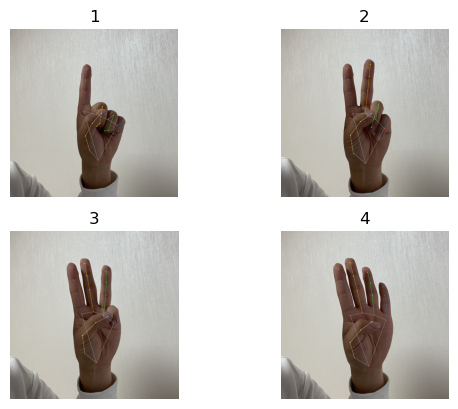

실제 1 -> 결과 1
실제 2 -> 결과 2
실제 3 -> 결과 3
실제 4 -> 결과 4


In [11]:
# 모델 테스트를 위한 사진 불러오기
X_test = []
y_test = []

fig = plt.figure()

with mp_hands.Hands(static_image_mode=True) as hands:
    for i in range(1, 4+1):
        path = f'images/validation/{i}.jpeg'
        image = load_image(path)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.multi_hand_landmarks:
            landmark = results.multi_hand_landmarks[0].landmark

            coordinate = []
            for n in range(21):
                coordinate.extend([landmark[n].x, landmark[n].y])

            X_test.append(coordinate)
            y_test.append(i)
            
            mp_drawing.draw_landmarks(
                image,
                results.multi_hand_landmarks[0],
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

            fig.add_subplot(2, 2, i)
            plt.title(i)
            show_image(image)

plt.show()

# 모델 결과 확인
for i in range(4):
    result = svc.predict([X_test[i]])
    print(f'실제 {y_test[i]} -> 결과 {result[0]}')

In [12]:
# 모델 저장
joblib.dump(svc, 'hand_model.pkl')

['hand_model.pkl']

In [13]:
# 모델 불러오기 테스트
loaded_model = joblib.load('hand_model.pkl')
result = loaded_model.predict([X_test[0]])
print(f'실제 {y_test[0]} -> 결과 {result[0]}')

실제 1 -> 결과 1
